<a href="https://colab.research.google.com/github/KaziMuktadirAhmed/QAOA-implementation/blob/main/QAOA_implementation_pennylane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pennylane seaborn

In [2]:
import pennylane as qml

H = qml.Hamiltonian([1, 1, 0.5], [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)])
print(H)

1 * X(0) + 1 * Z(1) + 0.5 * (X(0) @ X(1))


In [3]:
dev = qml.device("default.qubit", wires=2)

t = 1
n = 2


@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]


print(qml.draw(circuit, level="device")())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


In [4]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])


@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]


print(qml.draw(circuit)(0.5))

0: ──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X─┤  <Z>


In [5]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]


print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


In [6]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

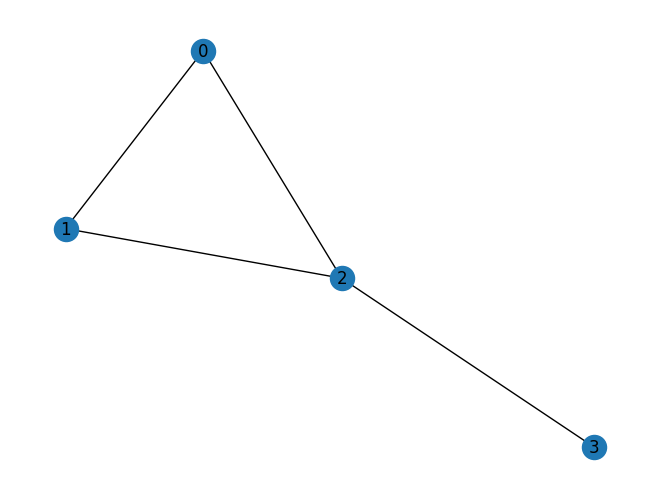

In [7]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)

nx.draw(graph, with_labels=True, pos=positions)
plt.show()

In [8]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


In [9]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [10]:
wires = range(4)
depth = 2


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [12]:
dev = qml.device("lightning.qubit", wires=wires)


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [13]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [14]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


In [15]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

In [19]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


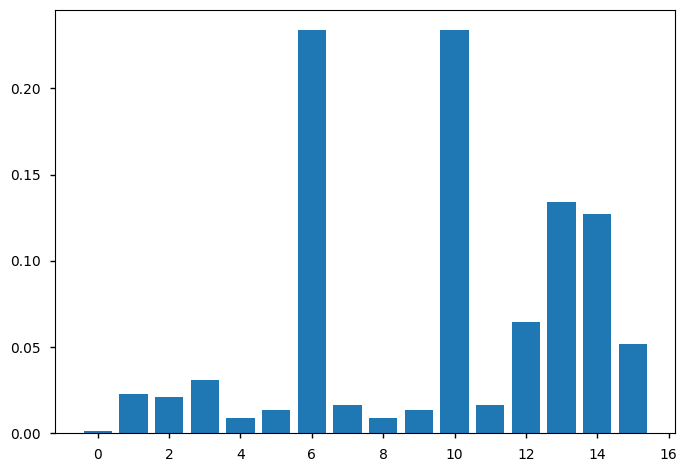

In [20]:
plt.style.use("seaborn-v0_8-notebook")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [21]:
reward_h = qaoa.edge_driver(nx.Graph([(0, 2)]), ["11"])

In [22]:
new_cost_h = cost_h + 2 * reward_h

In [23]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(new_cost_h)


params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.45959941 0.96095271]
 [0.27029962 0.78042396]]


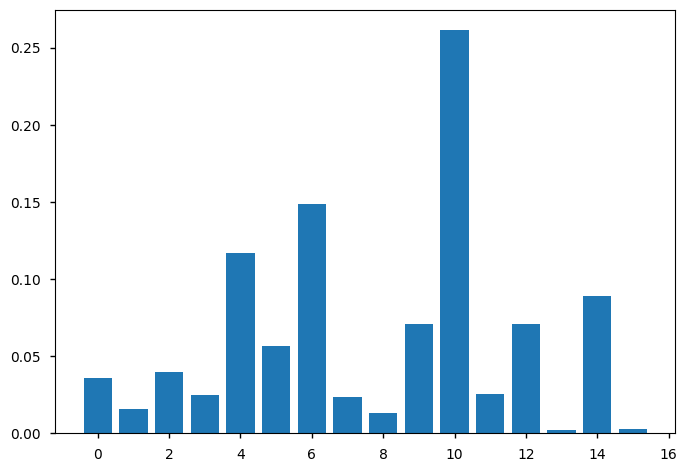

In [24]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

plt.style.use("seaborn-v0_8-notebook")
plt.bar(range(2 ** len(wires)), probs)
plt.show()